In [1]:
%env SOCCERDATA_LOGLEVEL=ERROR
%env SOCCERDATA_NOCACHE=True
%env SOCCERDATA_NOSTORE=True

env: SOCCERDATA_LOGLEVEL=ERROR
env: SOCCERDATA_NOCACHE=True
env: SOCCERDATA_NOSTORE=True


In [2]:
import soccerdata as sd

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_context("notebook")
sns.set_style("whitegrid")


# Home team advantage in the Italian Serie A
We all know sports teams have an advantage when playing at home. Here's a look at home team advantage for 5 years of the Serie A.

In [4]:
seriea_hist = sd.MatchHistory('ITA-Serie A', range(2018, 2023))
games = seriea_hist.read_games()
games.sample(5)

/cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccerdata/soccerdata/_common.py:471: UserWarning: Season id "2021" is ambiguous: interpreting as "20-21"
  warnings.warn(msg, stacklevel=1)


date  \
league      season game                                              
ITA-Serie A 1819   2018-12-22 Lazio-Cagliari   2018-12-22 12:00:00   
            2021   2020-12-20 Torino-Bologna   2020-12-20 11:30:00   
            1819   2019-03-03 Udinese-Bologna  2019-03-03 12:00:00   
            2021   2021-02-20 Genoa-Verona     2021-02-20 17:00:00   
            1819   2019-03-10 Fiorentina-Lazio 2019-03-10 12:00:00   

                                                 home_team away_team  FTHG  \
league      season game                                                      
ITA-Serie A 1819   2018-12-22 Lazio-Cagliari         Lazio  Cagliari     3   
            2021   2020-12-20 Torino-Bologna        Torino   Bologna     1   
            1819   2019-03-03 Udinese-Bologna      Udinese   Bologna     2   
            2021   2021-02-20 Genoa-Verona           Genoa    Verona     2   
            1819   2019-03-10 Fiorentina-Lazio  Fiorentina     Lazio     1   

                                                FTAG FTR  HTHG  HTAG HTR  HS  \
league      season game                                                        
ITA-Serie A 1819   2018-12-22 Lazio-Cagliari       1   H     2     0   H  15   
            2021   2020-12-20 Torino-Bologna       1   D     0     0   D  13   
            1819   2019-03-03 Udinese-Bologna      1   H     1     1   D  11   
            2021   2021-02-20 Genoa-Verona         2   D     0     1   A  12   
            1819   2019-03-10 Fiorentina-Lazio     1   D     0     1   A   7   

                                                ...  AvgC<2.5  AHCh  B365CAHH  \
league      season game                         ...                             
ITA-Serie A 1819   2018-12-22 Lazio-Cagliari    ...       NaN   NaN       NaN   
            2021   2020-12-20 Torino-Bologna    ...      2.25   0.0      1.91   
            1819   2019-03-03 Udinese-Bologna   ...       NaN   NaN       NaN   
            2021   2021-02-20 Genoa-Verona      ...      1.64   0.0      1.95   
            1819   2019-03-10 Fiorentina-Lazio  ...       NaN   NaN       NaN   

                                                B365CAHA  PCAHH  PCAHA  \
league      season game                                                  
ITA-Serie A 1819   2018-12-22 Lazio-Cagliari         NaN    NaN    NaN   
            2021   2020-12-20 Torino-Bologna        2.02   1.92    2.0   
            1819   2019-03-03 Udinese-Bologna        NaN    NaN    NaN   
            2021   2021-02-20 Genoa-Verona          1.98   1.93    2.0   
            1819   2019-03-10 Fiorentina-Lazio       NaN    NaN    NaN   

                                                MaxCAHH  MaxCAHA  AvgCAHH  \
league      season game                                                     
ITA-Serie A 1819   2018-12-22 Lazio-Cagliari        NaN      NaN      NaN   
            2021   2020-12-20 Torino-Bologna       1.94     2.11     1.86   
            1819   2019-03-03 Udinese-Bologna       NaN      NaN      NaN   
            2021   2021-02-20 Genoa-Verona         2.07     2.00     1.93   
            1819   2019-03-10 Fiorentina-Lazio      NaN      NaN      NaN   

                                                AvgCAHA  
league      season game                                  
ITA-Serie A 1819   2018-12-22 Lazio-Cagliari        NaN  
            2021   2020-12-20 Torino-Bologna       2.00  
            1819   2019-03-03 Udinese-Bologna       NaN  
            2021   2021-02-20 Genoa-Verona         1.93  
            1819   2019-03-10 Fiorentina-Lazio      NaN  

[5 rows x 121 columns]

In [5]:
def home_away_results(games: pd.DataFrame):
    """Returns aggregated home/away results per team"""
    
    res = (
        pd.melt(games.reset_index(),
                id_vars=['date', 'FTR'],
                value_name='team', var_name='is_home',
                value_vars=['home_team', 'away_team']))

    res.is_home = res.is_home.replace(['home_team', 'away_team'], ['Home', 'Away'])
    res['win'] = res['lose'] = res['draw'] = 0
    res.loc[(res['is_home'] == 'Home') & (res['FTR'] == 'H'), 'win'] = 1
    res.loc[(res['is_home'] == 'Away') & (res['FTR'] == 'A'), 'win'] = 1
    res.loc[(res['is_home'] == 'Home') & (res['FTR'] == 'A'), 'lose'] = 1
    res.loc[(res['is_home'] == 'Away') & (res['FTR'] == 'H'), 'lose'] = 1
    res.loc[res['FTR'] == 'D', 'draw'] = 1

    g = res.groupby(['team', 'is_home'])
    w = (g.win.agg(['sum', 'mean'])
         .rename(columns={'sum': 'n_win', 'mean': 'win_pct'}))
    l = (g.lose.agg(['sum', 'mean'])
         .rename(columns={'sum': 'n_lose', 'mean': 'lose_pct'}))
    d = (g.draw.agg(['sum', 'mean'])
         .rename(columns={'sum': 'n_draw', 'mean': 'draw_pct'}))

    res = pd.concat([w, l, d], axis=1)
    return res

In [6]:
results = home_away_results(games)
results.head(6)

n_win   win_pct  n_lose  lose_pct  n_draw  draw_pct
team      is_home                                                     
Atalanta  Away        52  0.547368      16  0.168421      27  0.284211
          Home        56  0.589474      23  0.242105      16  0.168421
Benevento Away        10  0.263158      18  0.473684      10  0.263158
          Home         4  0.105263      20  0.526316      14  0.368421
Bologna   Away        22  0.231579      48  0.505263      25  0.263158
          Home        35  0.368421      29  0.305263      31  0.326316

The overall picture shows most teams have a clear advantage at home:

/cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccerdata/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


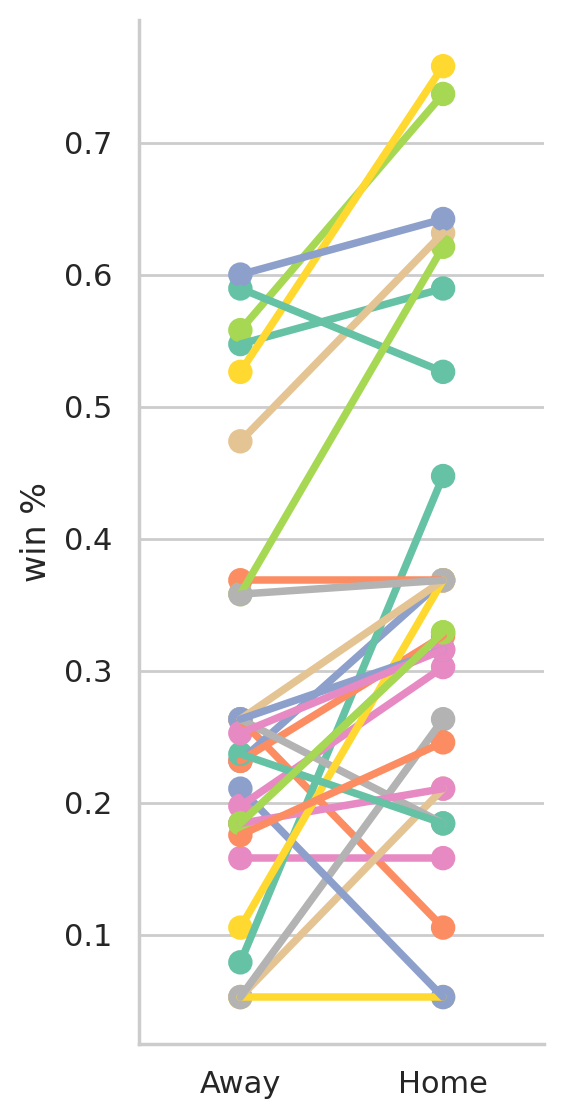

In [7]:
g = sns.FacetGrid(results.reset_index(), hue='team', palette='Set2', height=6, aspect=.5)
g.map(sns.pointplot, 'is_home', 'win_pct', order=["Away", "Home"])
g.set_axis_labels('', 'win %');

But there are a few exceptions.

/cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccerdata/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


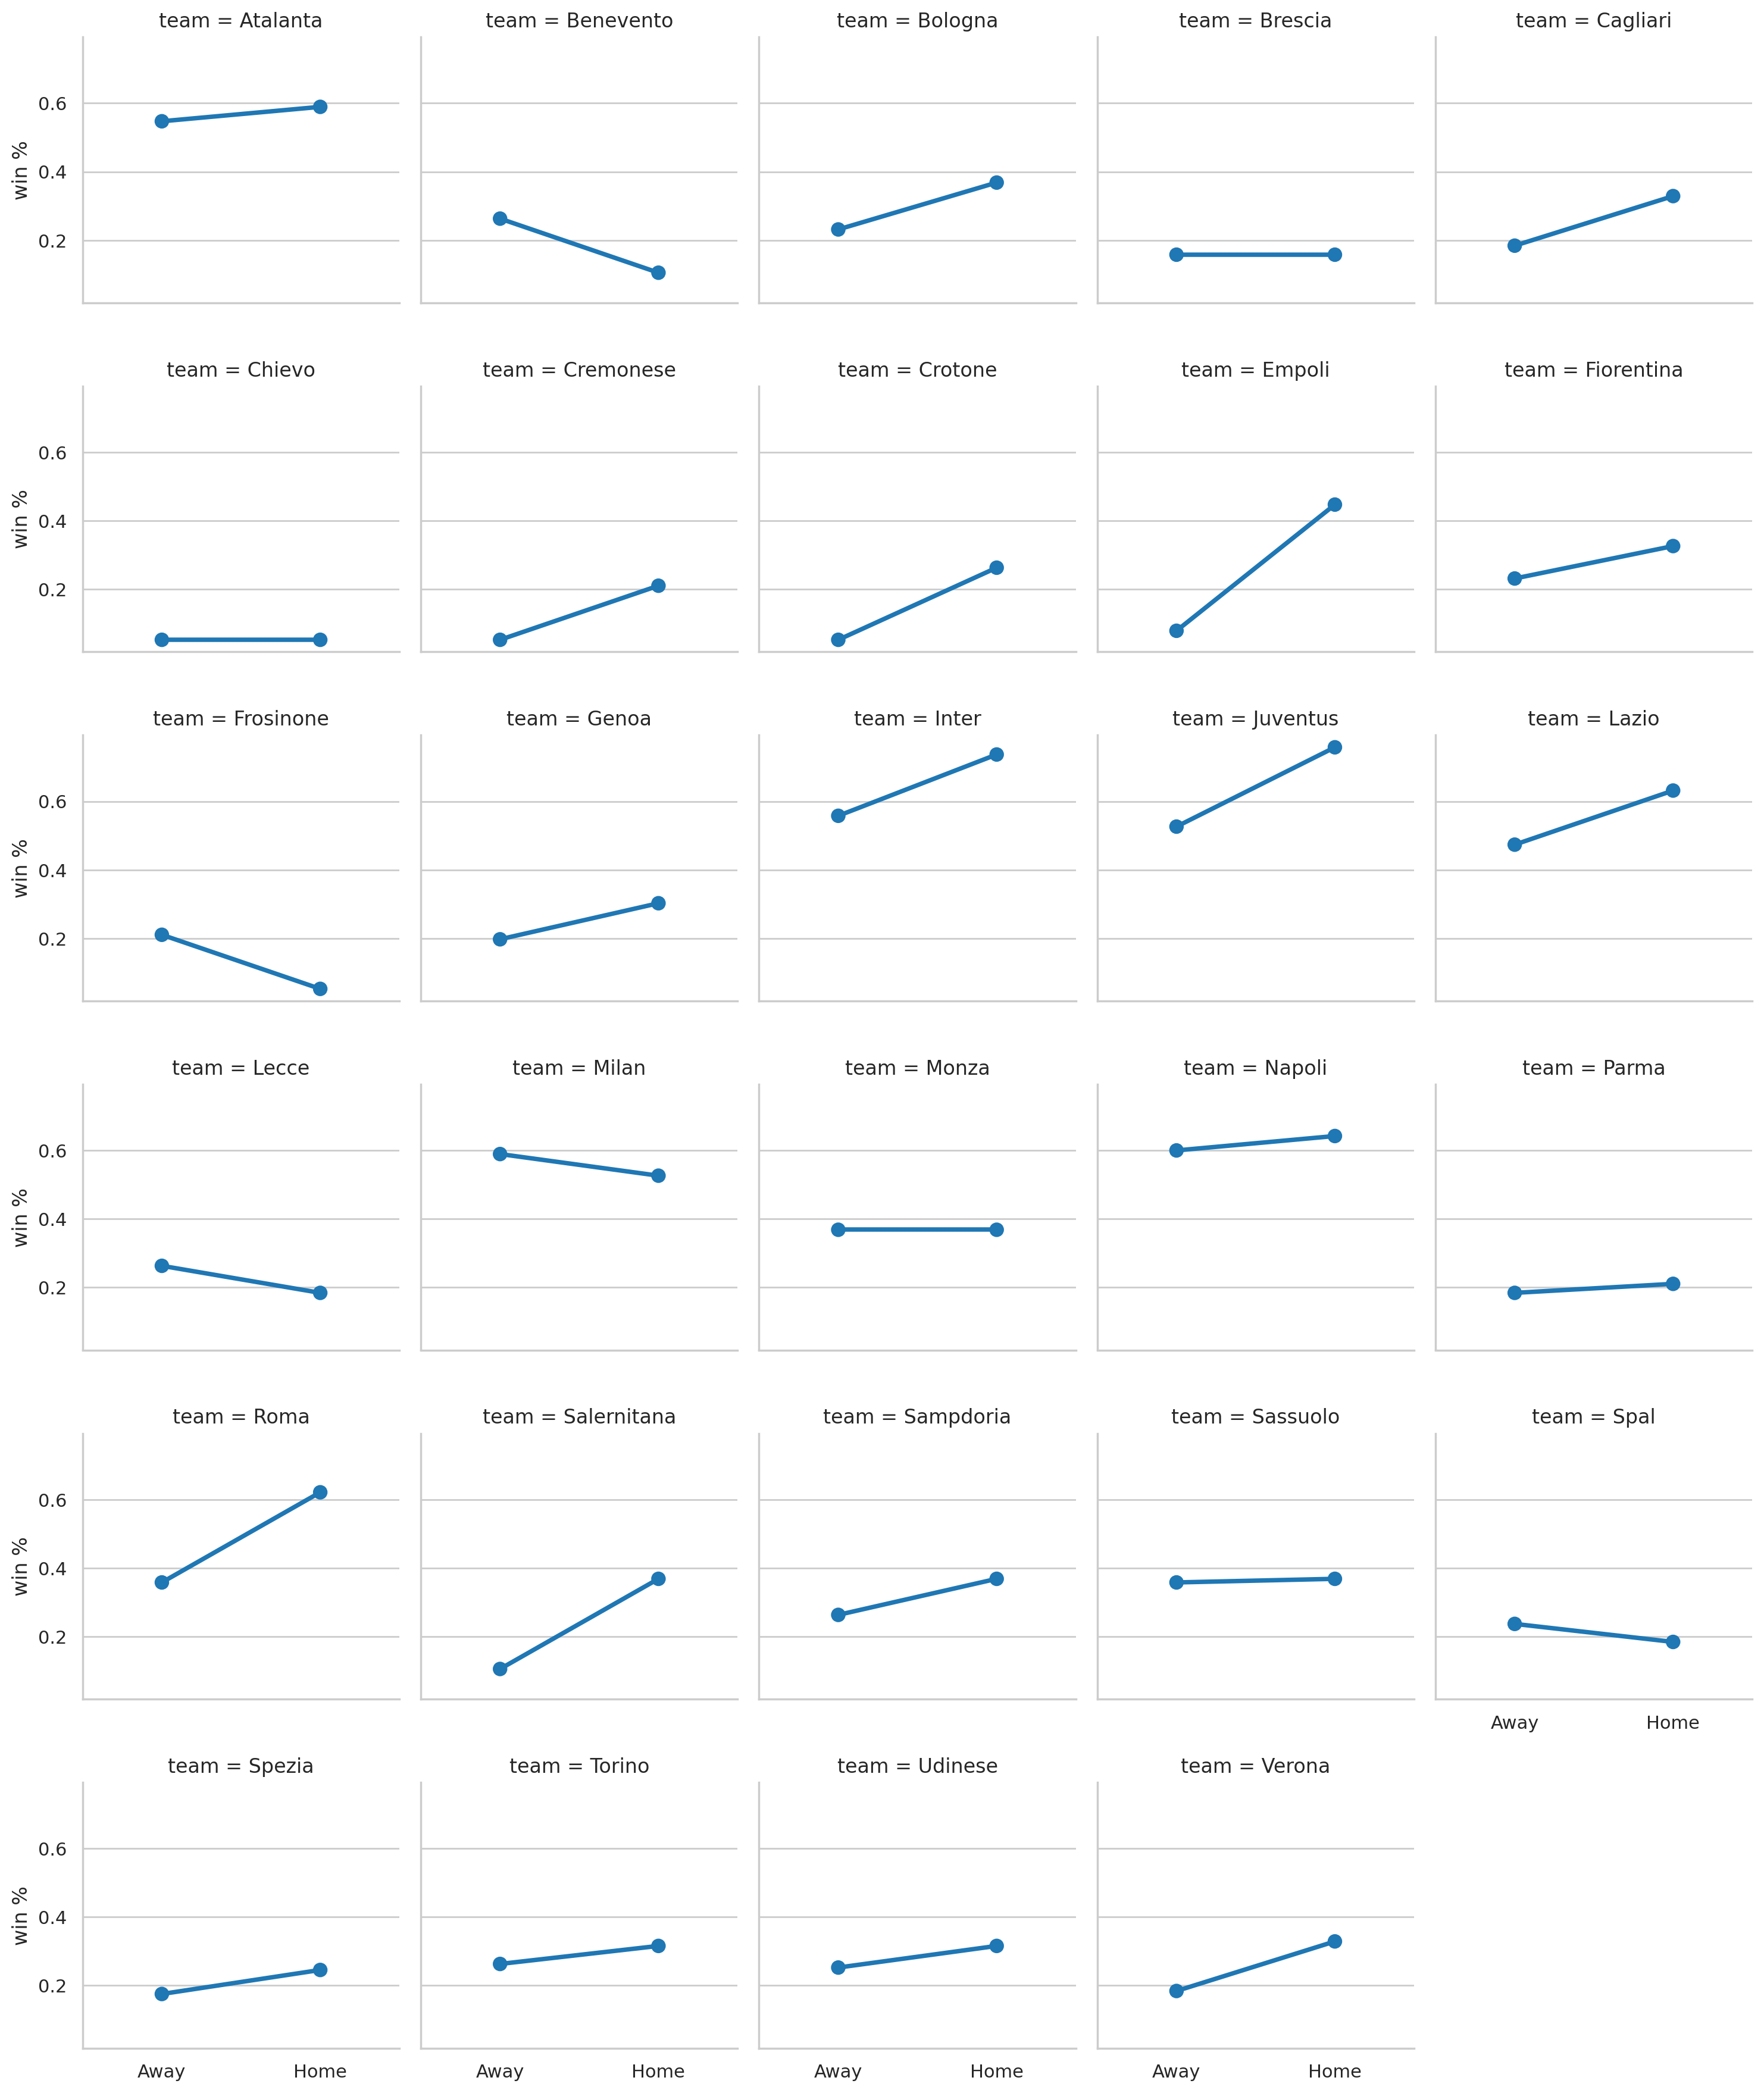

In [8]:
g = sns.FacetGrid(results.reset_index(), col='team', col_wrap=5)
g.map(sns.pointplot, 'is_home', 'win_pct', order=["Away", "Home"])
g.set_axis_labels('', 'win %');